In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [17]:
idle = pd.read_csv('data/idle.csv', index_col=0)
idle0 = idle.iloc[0]['Idle W']
idle['Idle W'] -= idle0
idle

,Idle W
#Busy,
0,0.000000
1,10.283708
2,12.248773
3,14.476905
4,16.816932
5,19.217805
6,21.921194
7,24.101344
8,26.641901


In [18]:
names = ['#Busy', '#Threads', 'Runtime (s)', 'Usertime (s)', 'Energy (J)', 'BG real', 'BG user']
df = pd.read_csv('data/matmul_1000_20.csv', names=names, usecols=[0, 1, 3, 4, 5, 6, 7])

df['Energy (J) w/ idle'] = df['Energy (J)']

user_max = df['Runtime (s)'] * df['#Threads']
user_pct = df['Usertime (s)'] / user_max
user_pct = user_pct.clip(upper=1.0)
df['Usertime (s)'] /= df['#Threads']
df['%User'] = user_pct

df['BG real'] /= 20
df['BG user'] /= 20
user_max = df['BG real'] * df['#Threads']
user_pct = df['BG user'] / user_max
user_pct = user_pct.clip(upper=1.0)
df['BG user'] /= df['#Threads']
df['%BG'] = user_pct

df['Energy (J)'] -= df['Runtime (s)'] * idle0
# TODO: Somehow subtract artificial BG energy
#idle_w = df.apply(lambda row: idle.iloc[int(row['#Busy'])]['Idle W'], axis=1)
#df['Energy (J)'] -= df['%BG'] * df['Runtime (s)'] * idle_w

df['Energy (J) User'] = df['Energy (J)'] * df['%User']

df

,#Busy,#Threads,Runtime (s),Usertime (s),Energy (J),BG real,BG user,Energy (J) w/ idle,%User,%BG,Energy (J) User
0,0,1,1.096011,1.095907,13.019546,1.096659,1.733000e-06,17.224593,0.999905,0.000002,13.018310
1,0,2,0.547694,0.547188,8.773985,0.547979,8.037500e-07,10.875311,0.999076,0.000001,8.765879
2,0,3,0.375297,0.374967,7.466704,0.375579,4.725000e-07,8.906600,0.999120,0.000001,7.460135
3,0,4,0.273624,0.273387,6.614836,0.273906,3.595000e-07,7.664644,0.999135,0.000001,6.609112
4,0,5,0.219485,0.219223,6.220748,0.219747,3.525000e-07,7.062842,0.998806,0.000002,6.213321
...,...,...,...,...,...,...,...,...,...,...,...
267,16,12,0.429394,0.228551,15.462842,0.437408,3.450657e-01,17.110289,0.532264,0.788888,8.230321
268,16,13,0.402594,0.211443,14.746733,0.408766,2.872483e-01,16.291358,0.525202,0.702721,7.745015
269,16,14,0.396943,0.208340,14.371475,0.404673,2.515193e-01,15.894417,0.524862,0.621537,7.543044
270,16,15,0.371094,0.193119,13.660449,0.378459,2.080625e-01,15.084220,0.520405,0.549763,7.108964


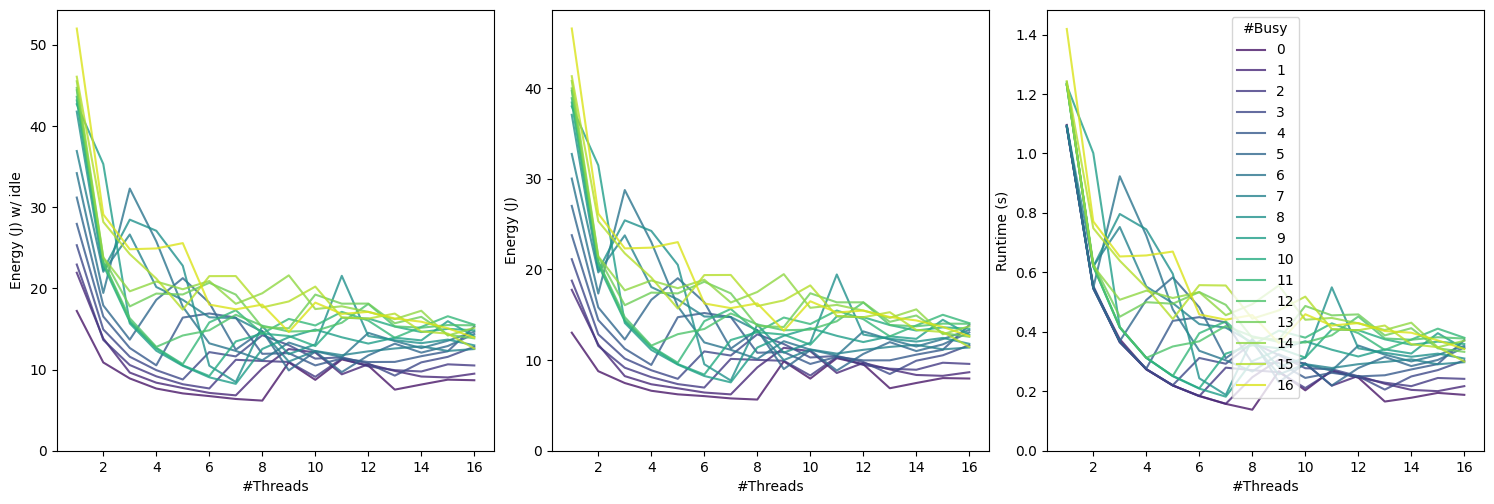

In [19]:
fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
fig.tight_layout()

hue = df['#Busy'].astype('category')

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J) w/ idle', hue=hue, palette='viridis', alpha=0.8, ax=ax_idle, legend=False)
ax_idle.set_ylim((0, None))

# Energy
sns.lineplot(df, x='#Threads', y='Energy (J)', hue=hue, palette='viridis', alpha=0.8, ax=ax_energy, legend=False)
ax_energy.set_ylim((0, None))

# Runtime
sns.lineplot(df, x='#Threads', y='Runtime (s)', hue=hue, palette='viridis', alpha=0.8, ax=ax_runtime)
ax_runtime.set_ylim((0, None))

plt.show()

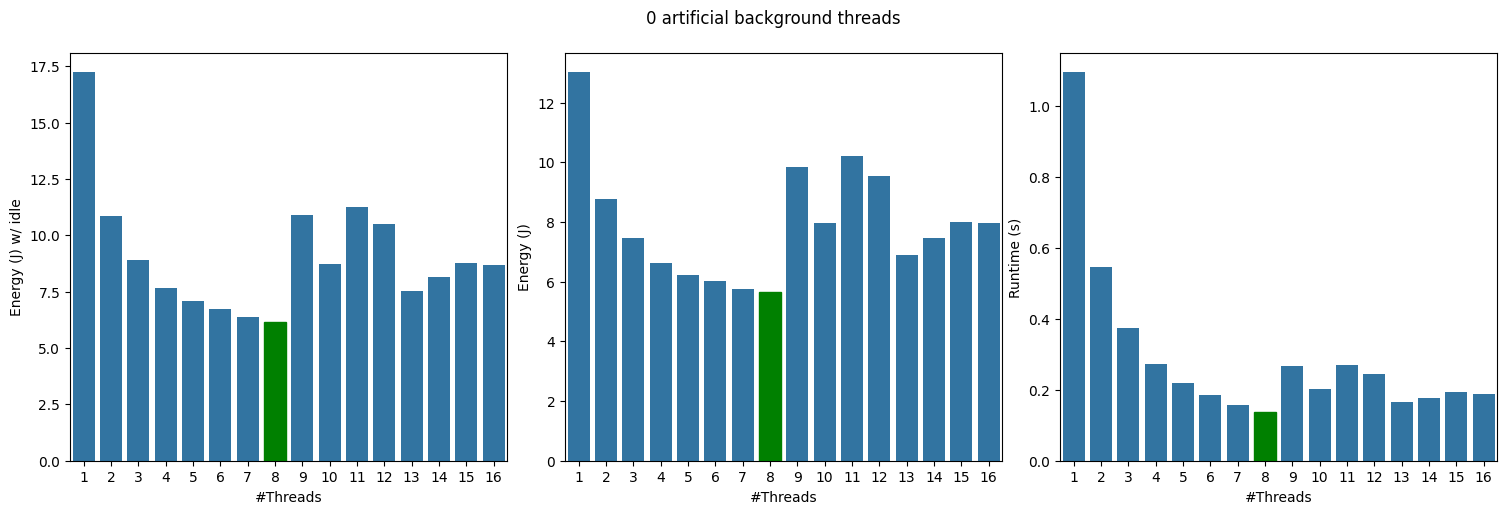

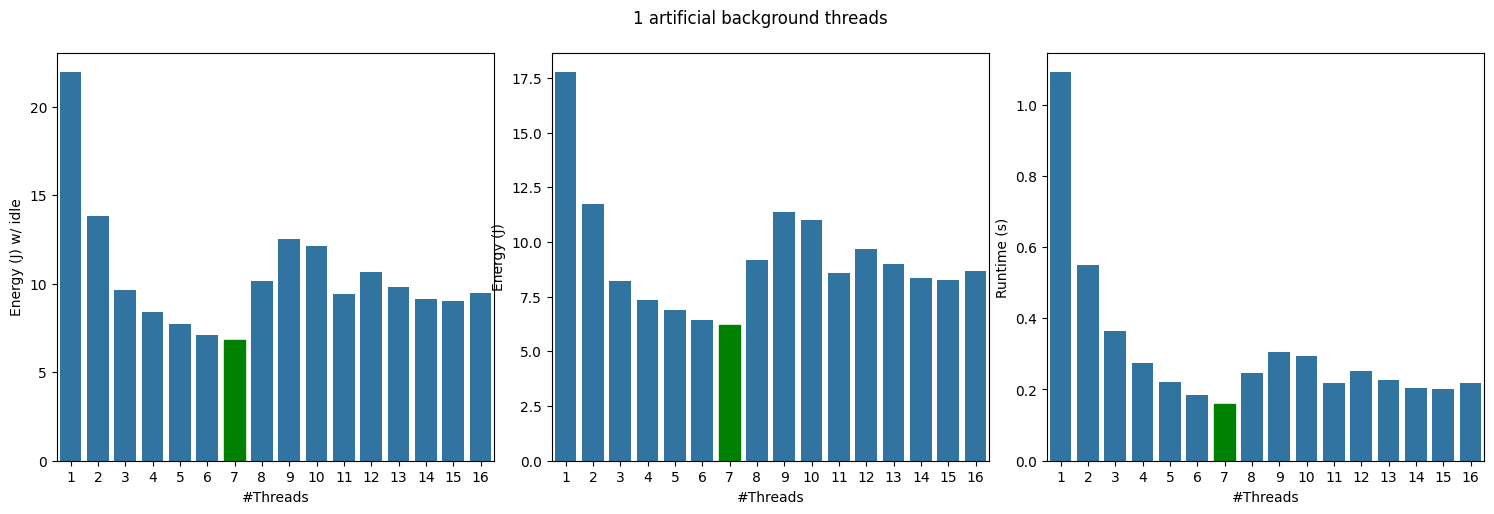

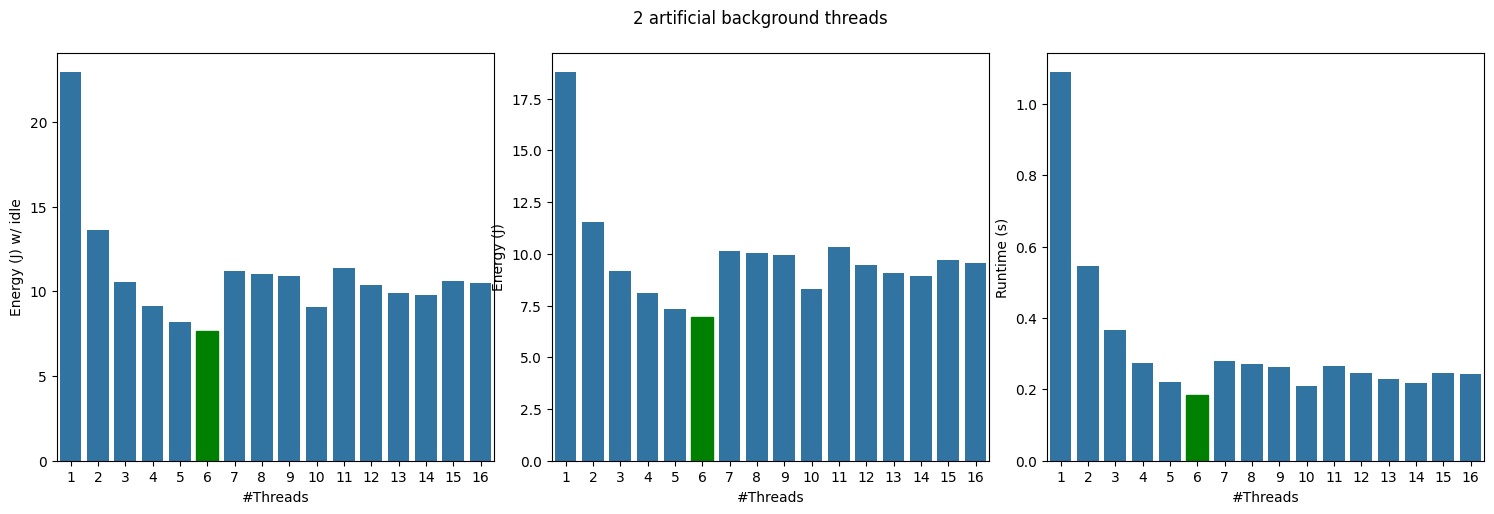

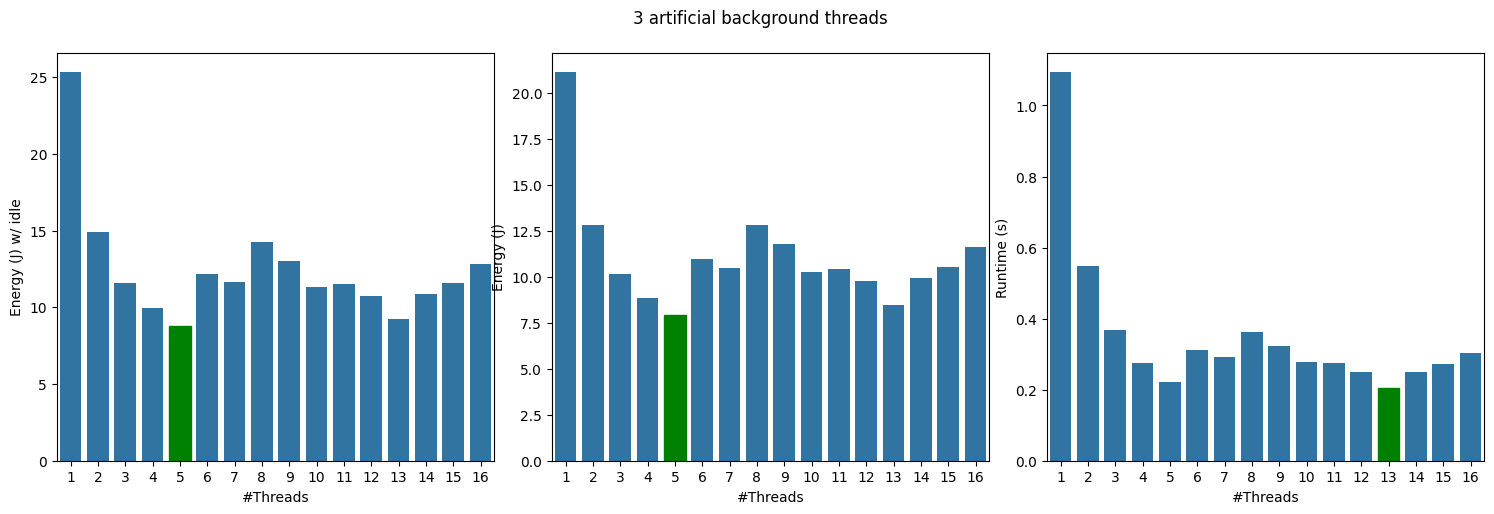

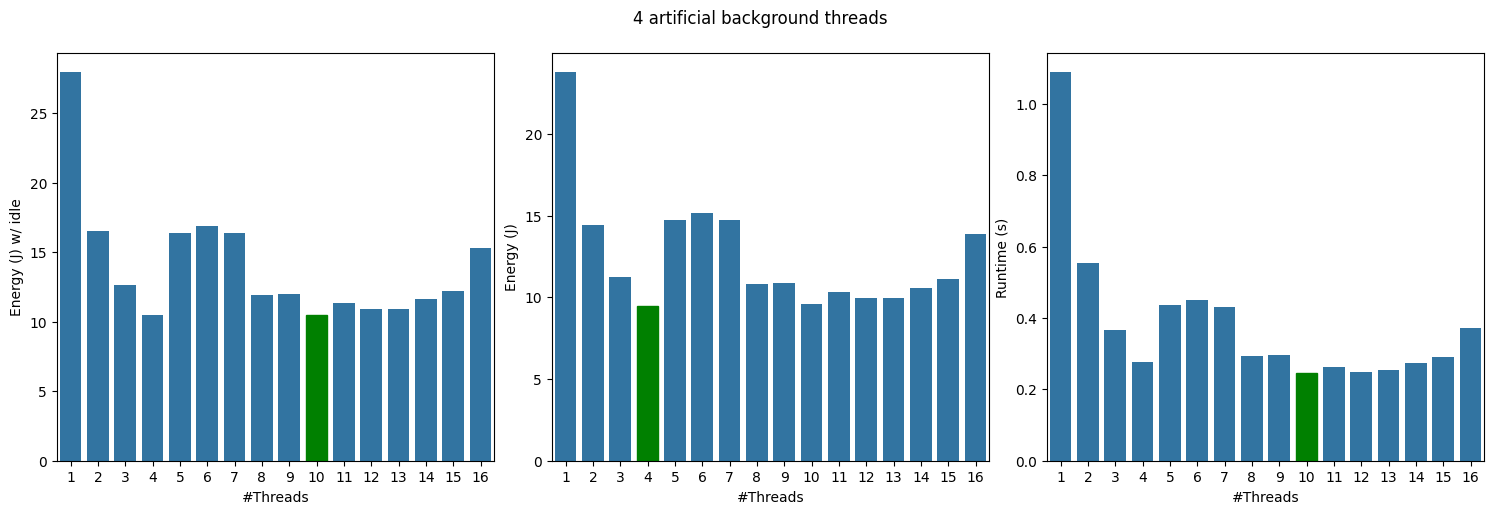

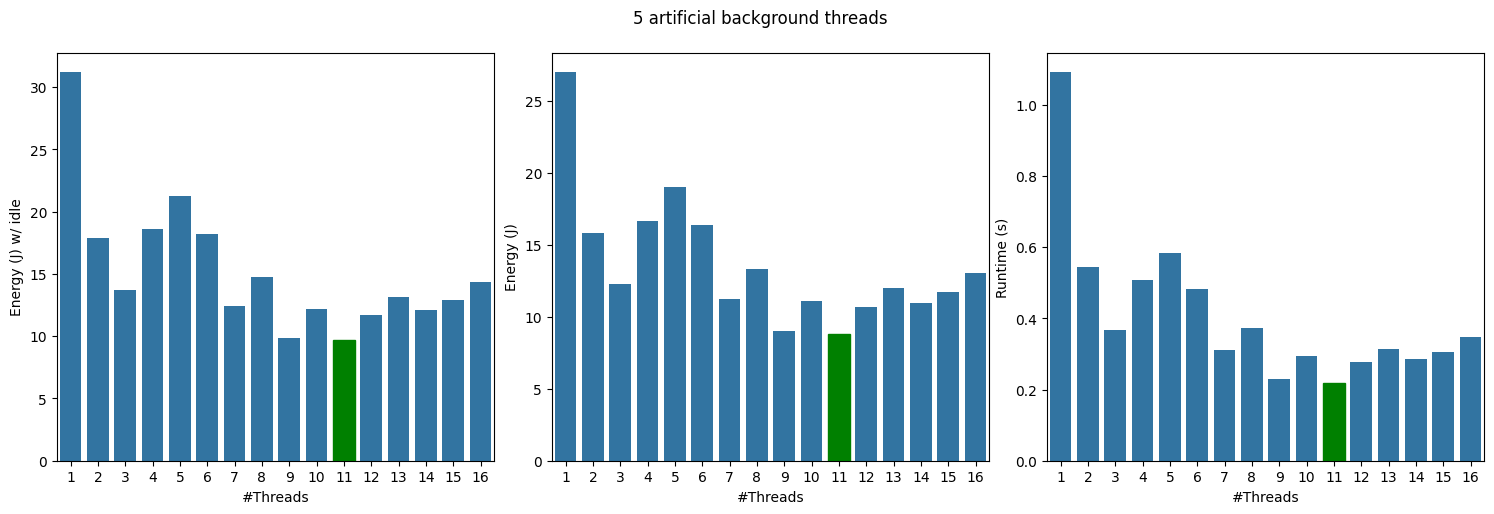

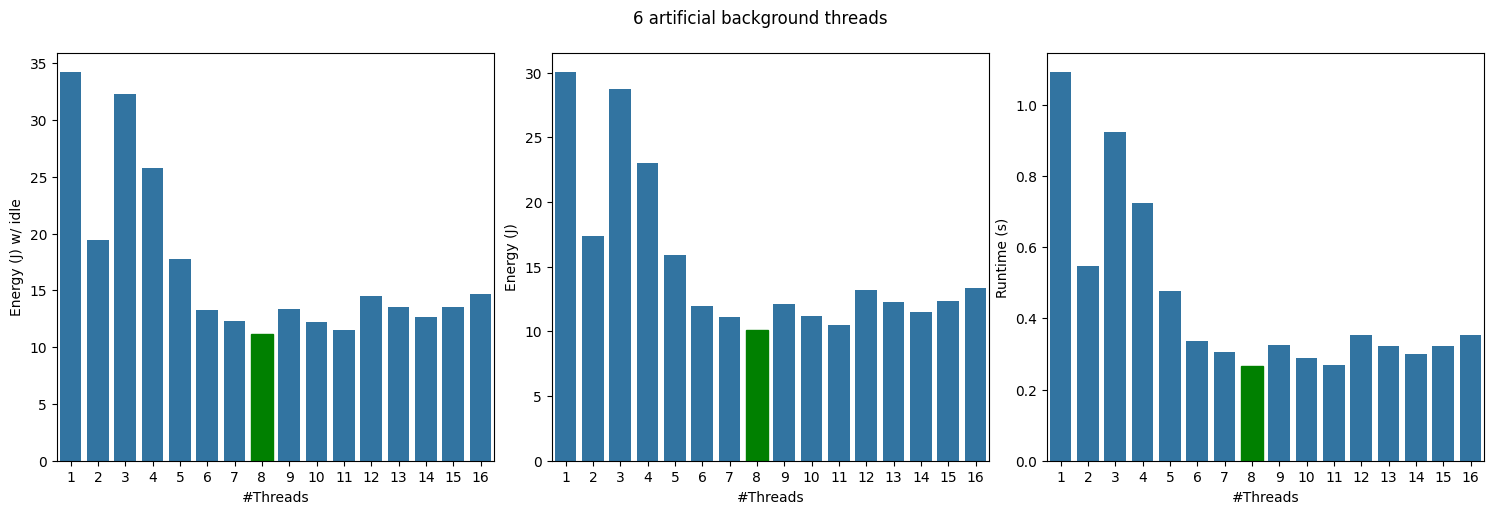

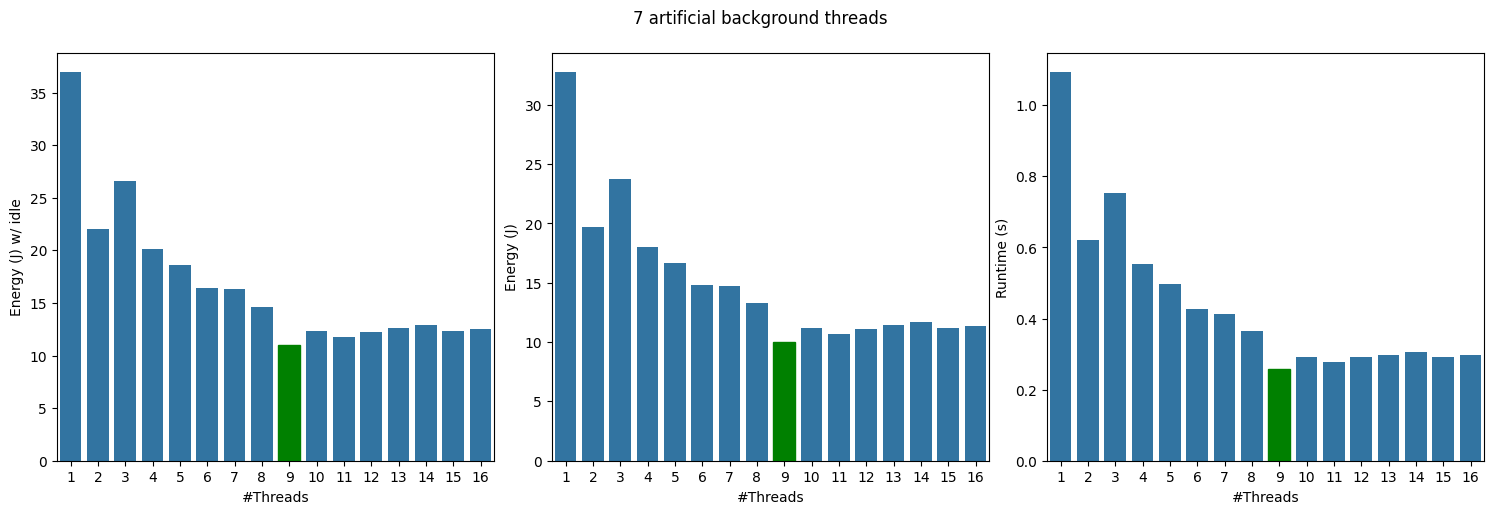

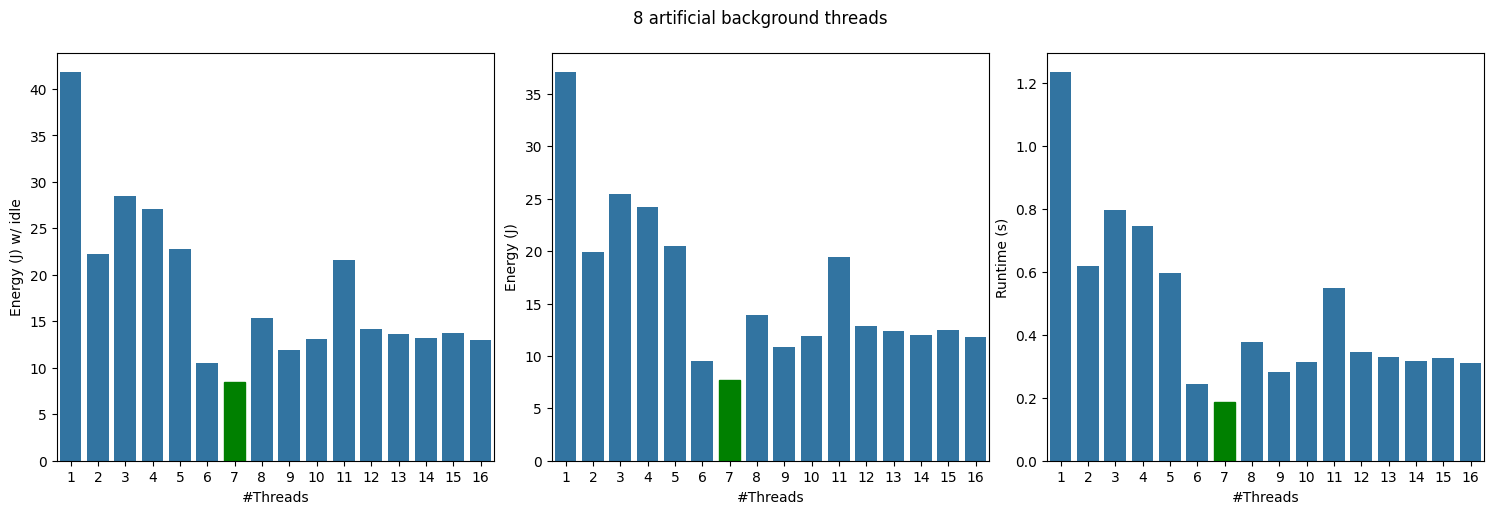

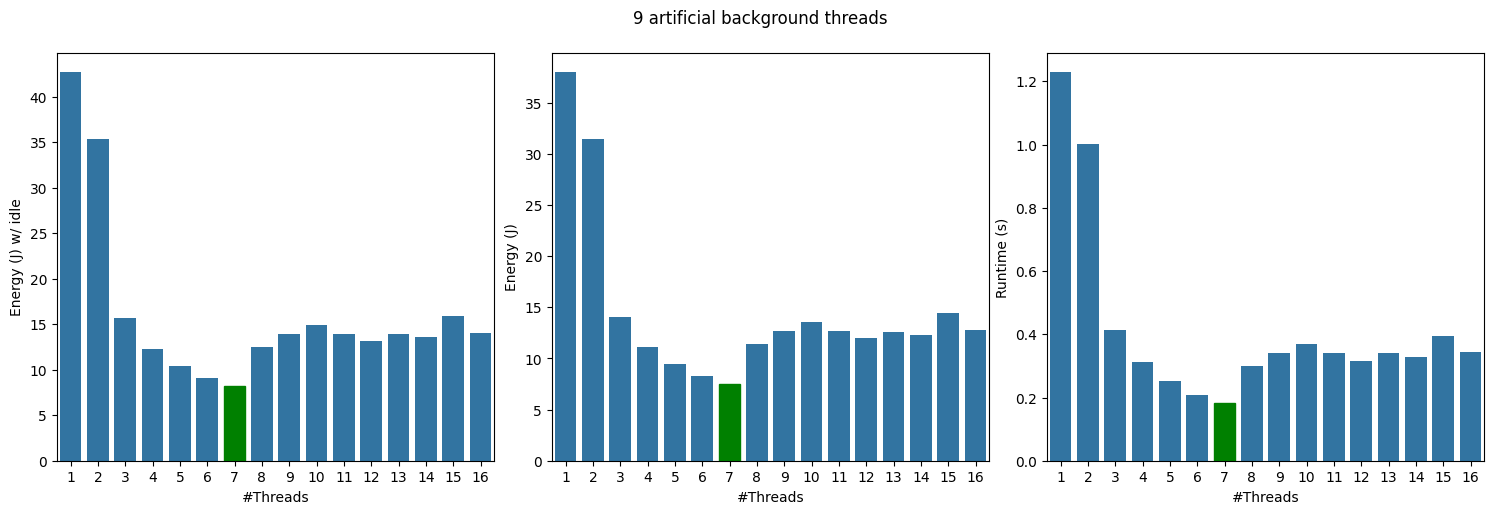

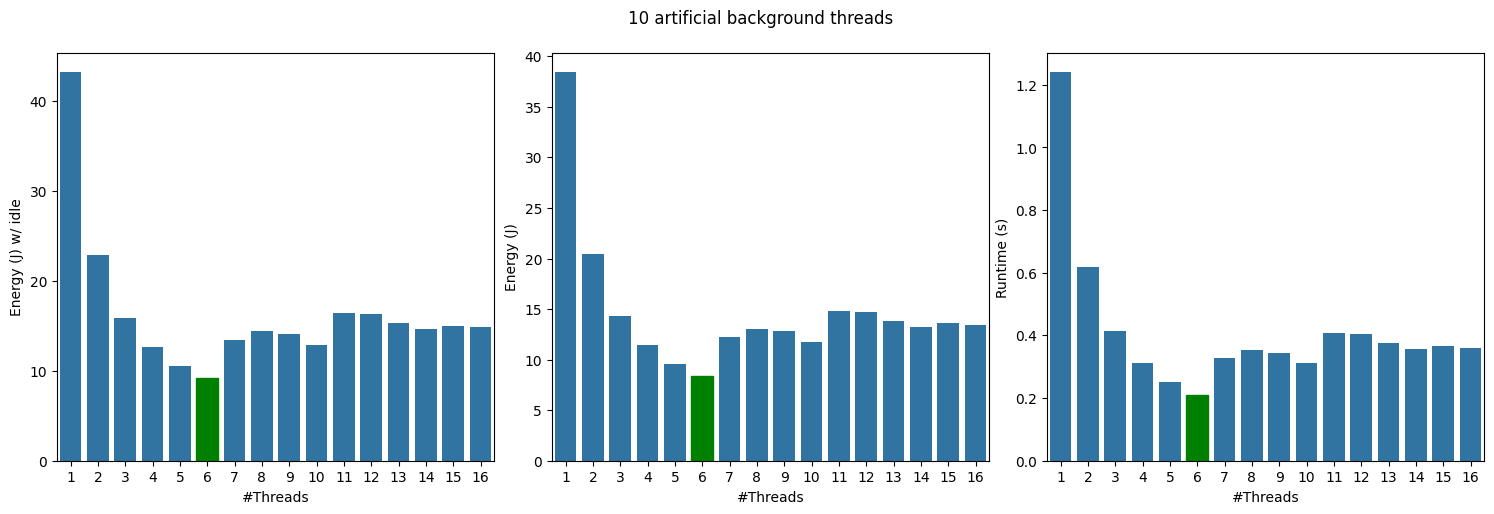

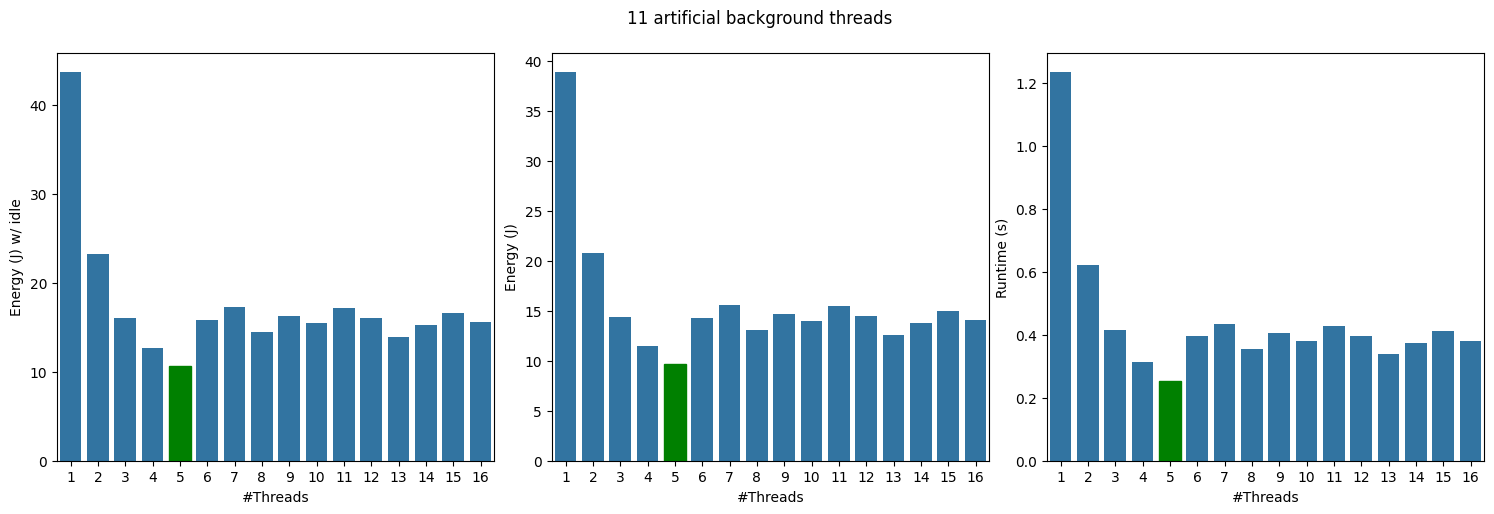

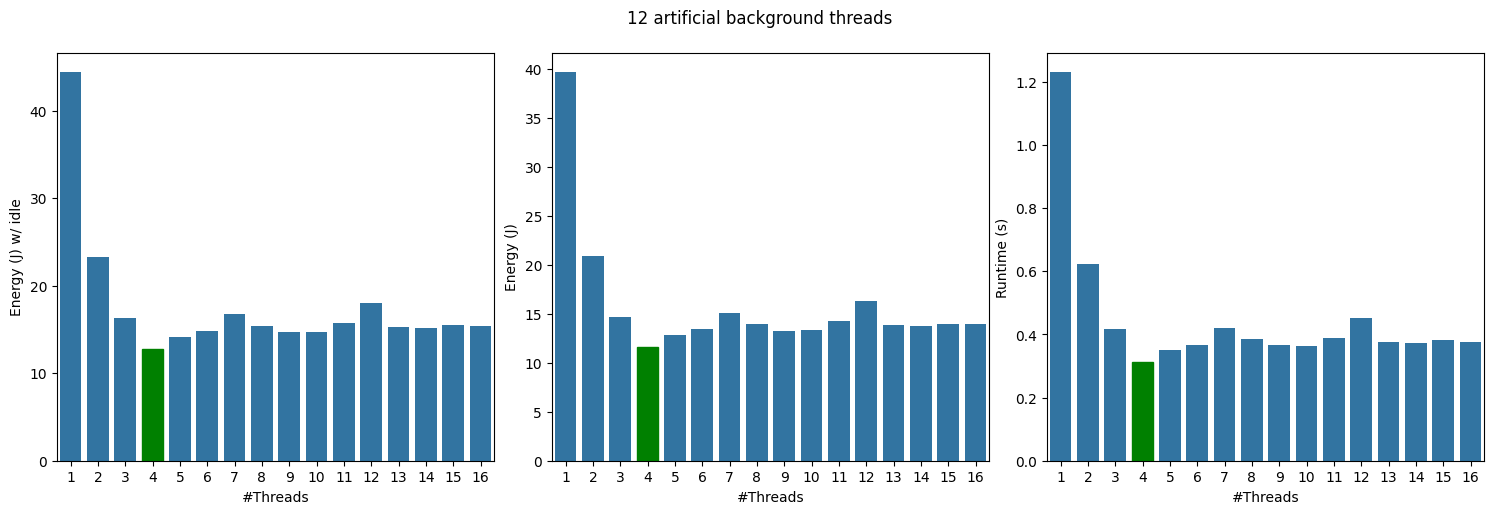

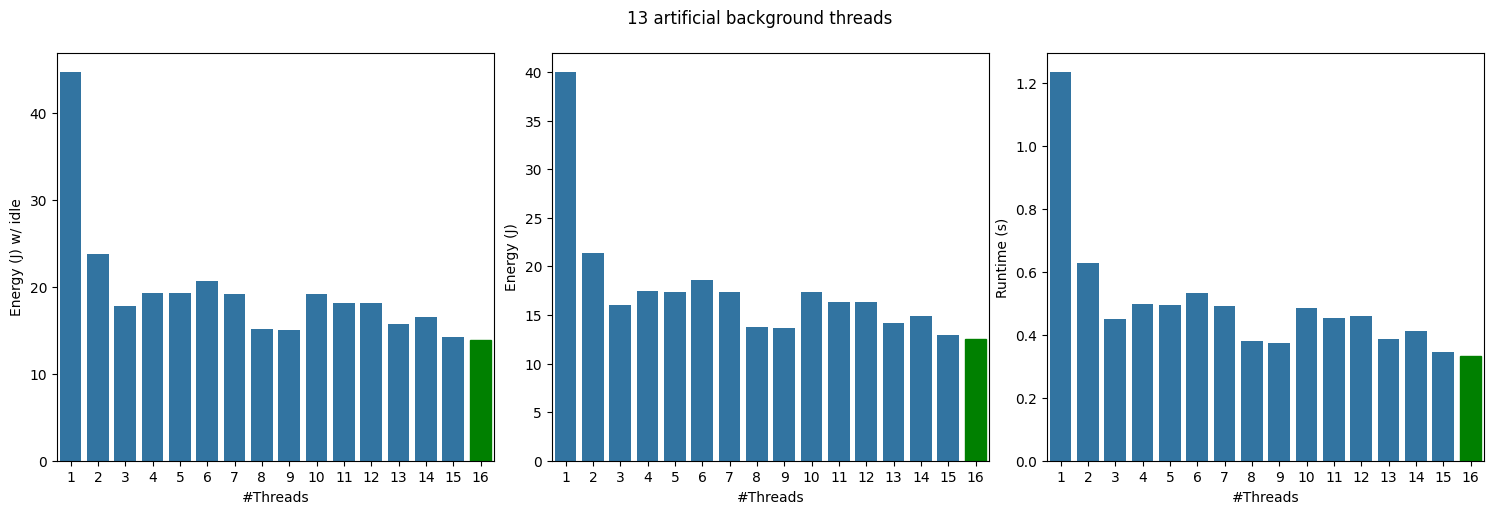

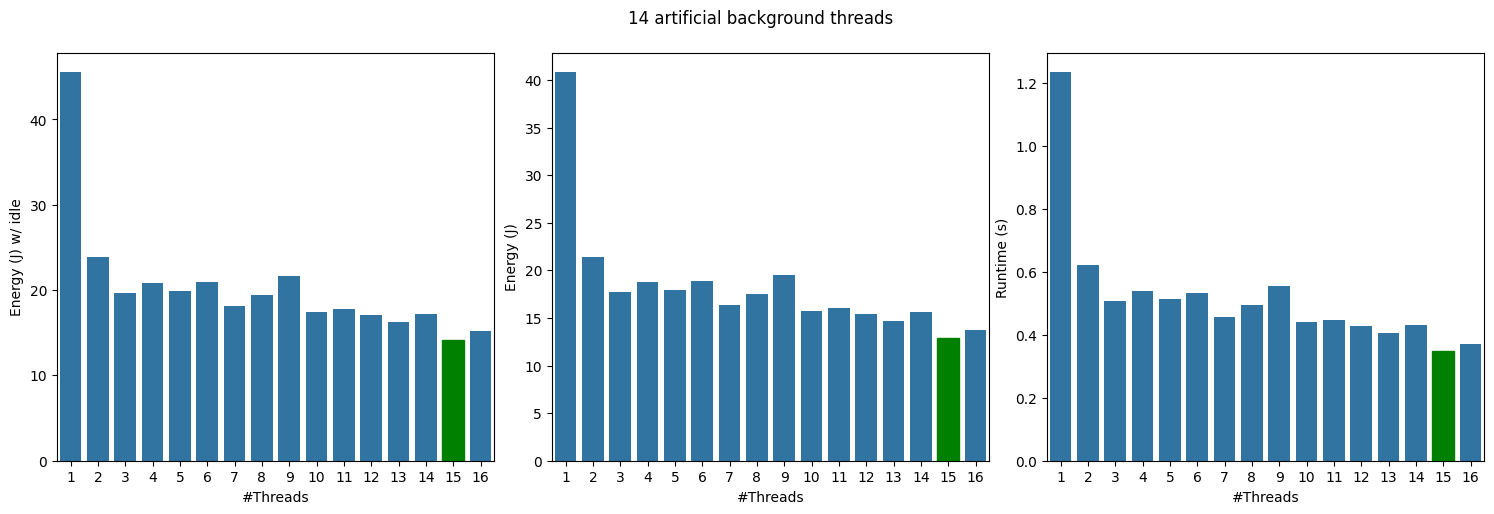

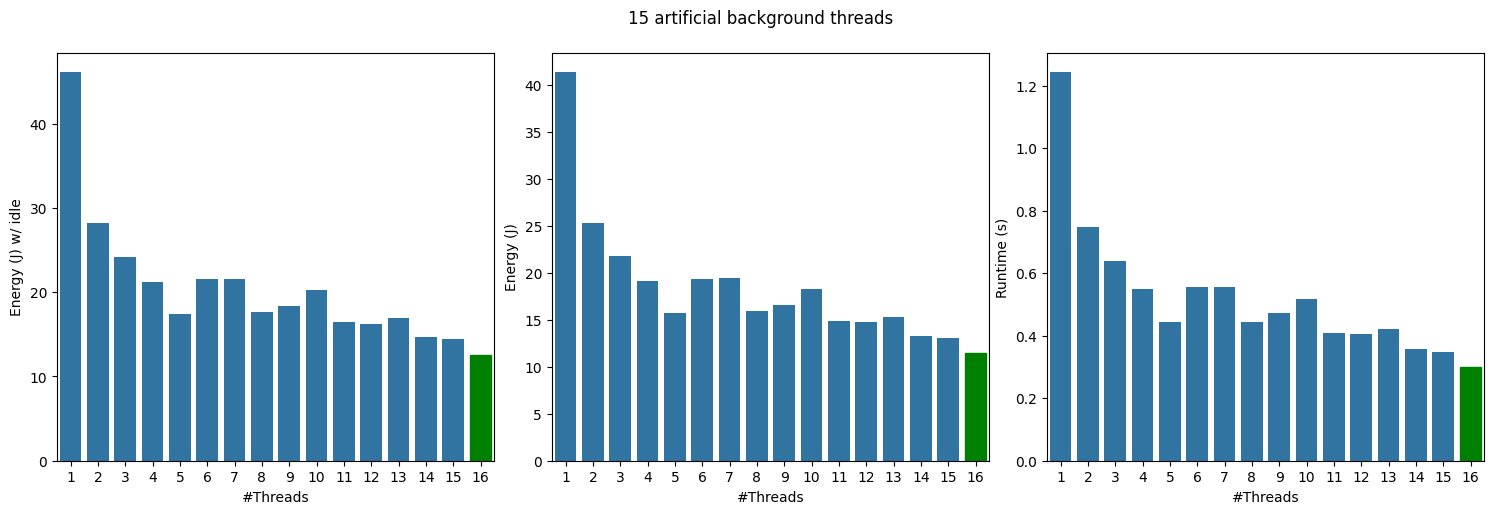

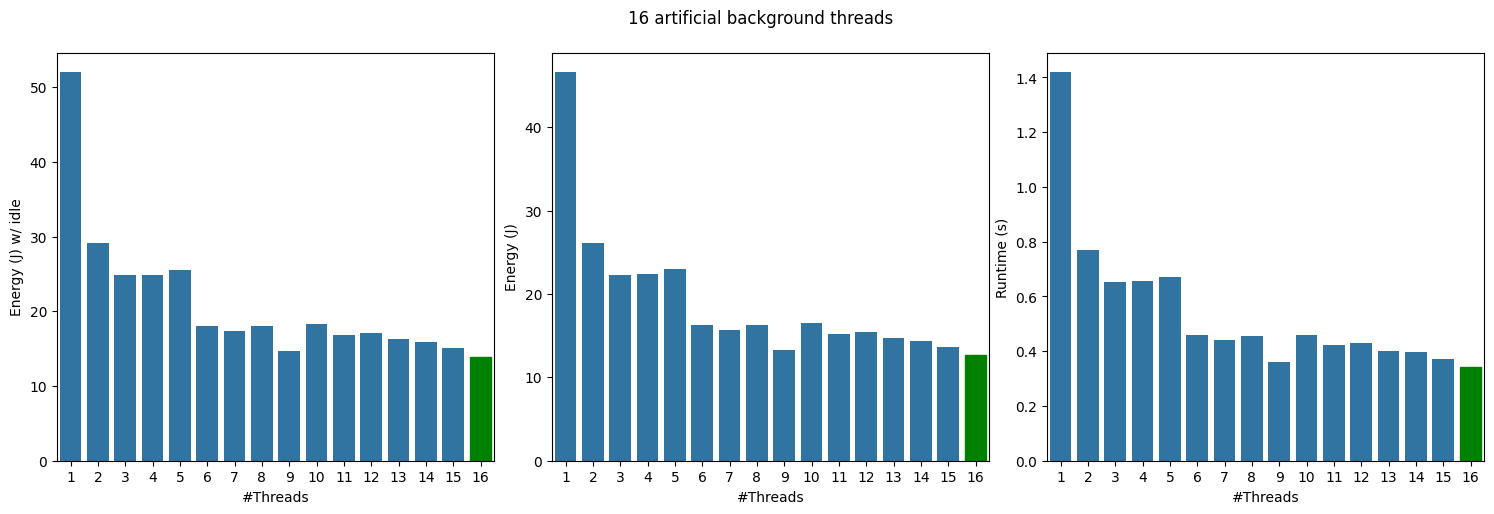

In [20]:
for busy in df['#Busy'].unique():
    dfx = df[df['#Busy'] == busy]
    
    fig, (ax_idle, ax_energy, ax_runtime) = plt.subplots(1, 3, figsize=(15,5))
    fig.suptitle(f'{busy} artificial background threads')
    fig.tight_layout()

    sns.barplot(dfx, x='#Threads', y='Energy (J) w/ idle', ax=ax_idle)
    sns.barplot(dfx, x='#Threads', y='Energy (J)', ax=ax_energy)
    sns.barplot(dfx, x='#Threads', y='Runtime (s)', ax=ax_runtime)
    
    def color_best(ax, col):
        for bar in ax.patches:
            if bar.get_height() == dfx[col].min():
                bar.set_color('g')
                return
    color_best(ax_idle, 'Energy (J) w/ idle')
    color_best(ax_energy, 'Energy (J)')
    color_best(ax_runtime, 'Runtime (s)')
    
    plt.show()

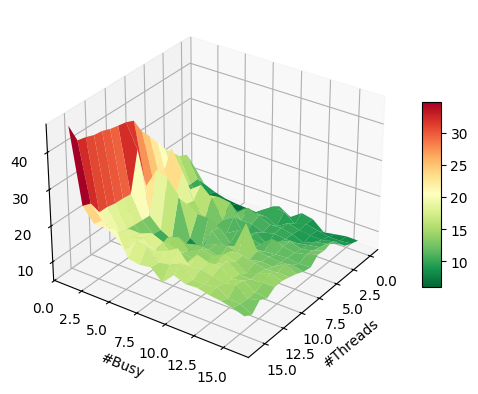

In [21]:
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import numpy as np

y1 = np.linspace(df['#Threads'].min(), df['#Threads'].max(), len(df['#Threads'].unique()))
x1 = np.linspace(df['#Busy'].min(), df['#Busy'].max(), len(df['#Busy'].unique()))

x2, y2 = np.meshgrid(x1, y1)

z2 = griddata((df['#Busy'], df['#Threads']), df['Energy (J)'], (x2, y2))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(x2, y2, z2, cmap='RdYlGn_r')

fig.colorbar(surf, shrink=0.5, aspect=10)
ax.set_xlabel('#Threads')
ax.set_ylabel('#Busy')

ax.view_init(30, 35)

plt.show()

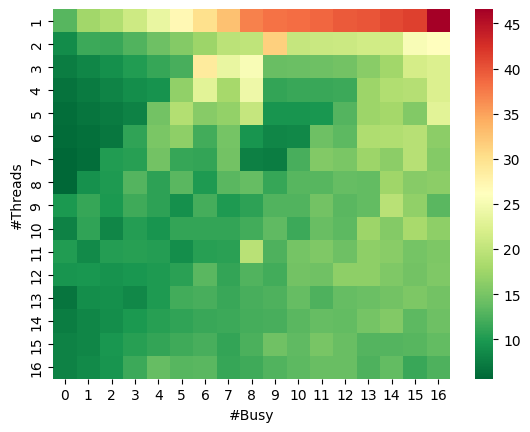

In [22]:
hm = df.pivot(index='#Threads', columns='#Busy', values='Energy (J)')
ax = sns.heatmap(hm, cmap='RdYlGn_r')
#ax.invert_yaxis()
plt.show()